In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
import kagglehub
antoreepjana_animals_detection_images_dataset_path = kagglehub.dataset_download('antoreepjana/animals-detection-images-dataset')

print('Data source import complete.')


100%|██████████| 8.92G/8.92G [07:00<00:00, 22.8MB/s]

Extracting files...


Data source import complete.


In [2]:
!pip install -q opencv-python lxml matplotlib imgaug
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -qr requirements.txt
%cd /content

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 52.1 MB/s eta 0:00:00
Cloning into 'yolov5'...
remote: Enumerating objects: 17739, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 17739 (delta 57), reused 31 (delta 31), pack-reused 17643 (from 4)
Receiving objects: 100% (17739/17739), 17.12 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (12052/12052), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 79.5 MB/s eta 0:00:00
/content


In [3]:
import os
import cv2 as cv
import glob as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model, layers, Sequential, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import callbacks, layers, Model
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [4]:
# Python cell
import os, shutil, random, glob, math
from pathlib import Path
import cv2, json
import numpy as np
import matplotlib.pyplot as plt

# Base path (from your kagglehub cell)..
BASE = antoreepjana_animals_detection_images_dataset_path
print("BASE dataset path:", BASE)

# Only use these 20 classes (exact folder names in the dataset)
CLASSES = [
 "Bull","Camel","Cattle","Deer","Elephant","Fox","Giraffe","Goat",
 "Horse","Kangaroo","Lion","Mule","Panda","Pig","Rabbit",
 "Hippopotamus","Raccoon","Rhinoceros","Sheep","Zebra"
]

CLASS2IDX = {c:i for i,c in enumerate(CLASSES)}

# Where we'll create the YOLO dataset structure
YOLO_ROOT = "/content/yolo_dataset"
os.makedirs(YOLO_ROOT, exist_ok=True)

print("CLASSES:", CLASSES)
print("YOLO_ROOT:", YOLO_ROOT)


BASE dataset path: /root/.cache/kagglehub/datasets/antoreepjana/animals-detection-images-dataset/versions/7
CLASSES: ['Bull', 'Camel', 'Cattle', 'Deer', 'Elephant', 'Fox', 'Giraffe', 'Goat', 'Horse', 'Kangaroo', 'Lion', 'Mule', 'Panda', 'Pig', 'Rabbit', 'Hippopotamus', 'Raccoon', 'Rhinoceros', 'Sheep', 'Zebra']
YOLO_ROOT: /content/yolo_dataset


Train folder exists: True
Test folder exists: True

Train counts (first 10):
Bull 47
Camel 67
Cattle 70
Deer 327
Elephant 155
Fox 148
Giraffe 298
Goat 202
Horse 400
Kangaroo 98


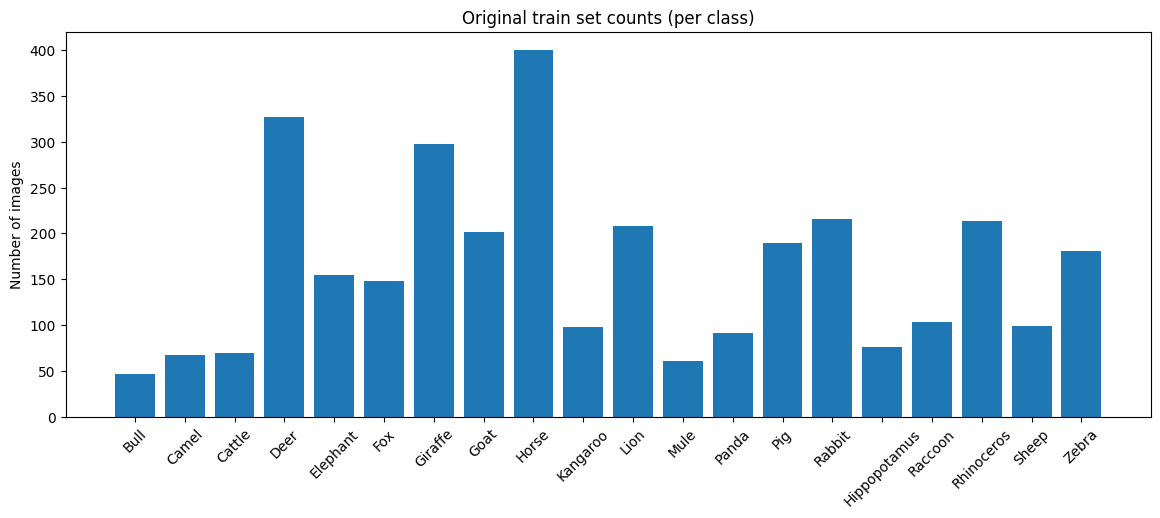

In [5]:
# Python cell: count images per class in original dataset folders
def count_folders(src_root):
    counts = {}
    for c in CLASSES:
        folder = os.path.join(src_root, c)
        if os.path.isdir(folder):
            imgs = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
            counts[c] = len(imgs)
        else:
            counts[c] = 0
    return counts

train_src = os.path.join(BASE, "train")
test_src  = os.path.join(BASE, "test")

print("Train folder exists:", os.path.isdir(train_src))
print("Test folder exists:", os.path.isdir(test_src))

train_counts = count_folders(train_src)
test_counts = count_folders(test_src)

print("\nTrain counts (first 10):")
for k in list(train_counts.keys())[:10]:
    print(k, train_counts[k])

# Plot distribution
plt.figure(figsize=(14,5))
plt.bar(range(len(CLASSES)), [train_counts[c] for c in CLASSES])
plt.xticks(range(len(CLASSES)), CLASSES, rotation=45)
plt.title("Original train set counts (per class)")
plt.ylabel("Number of images")
plt.show()


In [6]:
# Build YOLO directory & create splits, and auto-label each image with full-frame bbox
def make_splits_and_auto_label(src_roots, out_root, classes, test_ratio=0.1, val_ratio=0.1):
    # create structure
    for s in ["train","val","test"]:
        os.makedirs(os.path.join(out_root, s, "images"), exist_ok=True)
        os.makedirs(os.path.join(out_root, s, "labels"), exist_ok=True)
    # gather images (class, path)
    items = []
    for src in src_roots:
        for cls in classes:
            folder = os.path.join(src, cls)
            if not os.path.isdir(folder):
                continue
            for f in os.listdir(folder):
                if f.lower().endswith(('.jpg','.jpeg','.png')):
                    items.append((cls, os.path.join(folder, f)))
    random.shuffle(items)
    n = len(items)
    n_test = int(n * test_ratio)
    n_val = int(n * val_ratio)
    test_items = items[:n_test]
    val_items = items[n_test:n_test+n_val]
    train_items = items[n_test+n_val:]
    def copy_and_label(list_items, split):
        for cls, path in list_items:
            dst = os.path.join(out_root, split, "images", f"{cls}__{os.path.basename(path)}")
            shutil.copy(path, dst)
            # full-frame bbox
            cls_idx = CLASS2IDX[cls]
            with open(os.path.join(out_root, split, "labels", os.path.basename(dst).rsplit('.',1)[0] + ".txt"), "w") as f:
                f.write(f"{cls_idx} 0.5 0.5 1.0 1.0\n")
    copy_and_label(train_items, "train")
    copy_and_label(val_items, "val")
    copy_and_label(test_items, "test")
    print("Auto-labeled splits created. Train:", len(train_items), "Val:", len(val_items), "Test:", len(test_items))

# run it using both train and test source folders
make_splits_and_auto_label([train_src, test_src], YOLO_ROOT, CLASSES)


Auto-labeled splits created. Train: 3755 Val: 469 Test: 469


In [7]:
# If you converted XMLs into YOLO format under YOLO_ROOT/raw_images and raw_annotations_xml,
# move them into train/val/test splits (80/10/10)
raw_img_dir = os.path.join(YOLO_ROOT, "raw_images")
raw_lbl_dir = os.path.join(YOLO_ROOT, "raw_annotations_xml")

if os.path.isdir(raw_img_dir) and len(os.listdir(raw_img_dir))>0:
    files = [f for f in os.listdir(raw_img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    random.shuffle(files)
    n = len(files)
    n_val = int(n*0.1); n_test = int(n*0.1)
    val_files = files[:n_val]; test_files = files[n_val:n_val+n_test]; train_files = files[n_val+n_test:]
    for split, flist in [("train",train_files),("val",val_files),("test",test_files)]:
        os.makedirs(os.path.join(YOLO_ROOT, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(YOLO_ROOT, split, "labels"), exist_ok=True)
        for fn in flist:
            shutil.copy(os.path.join(raw_img_dir, fn), os.path.join(YOLO_ROOT, split, "images", fn))
            lbl_src = os.path.join(raw_lbl_dir, fn.rsplit('.',1)[0] + ".txt")
            if os.path.exists(lbl_src):
                shutil.copy(lbl_src, os.path.join(YOLO_ROOT, split, "labels", fn.rsplit('.',1)[0] + ".txt"))
    print("Assembled splits from raw_images")
else:
    print("No raw_images found; assume Option B was used or labels already in YOLO_ROOT splits.")


No raw_images found; assume Option B was used or labels already in YOLO_ROOT splits.


Train label counts (YOLO):
Bull 97
Camel 74
Cattle 187
Deer 412
Elephant 147
Fox 178
Giraffe 259
Goat 227
Horse 433
Kangaroo 124
Lion 244
Mule 76
Panda 86
Pig 229
Rabbit 271
Hippopotamus 75
Raccoon 132
Rhinoceros 192
Sheep 134
Zebra 178


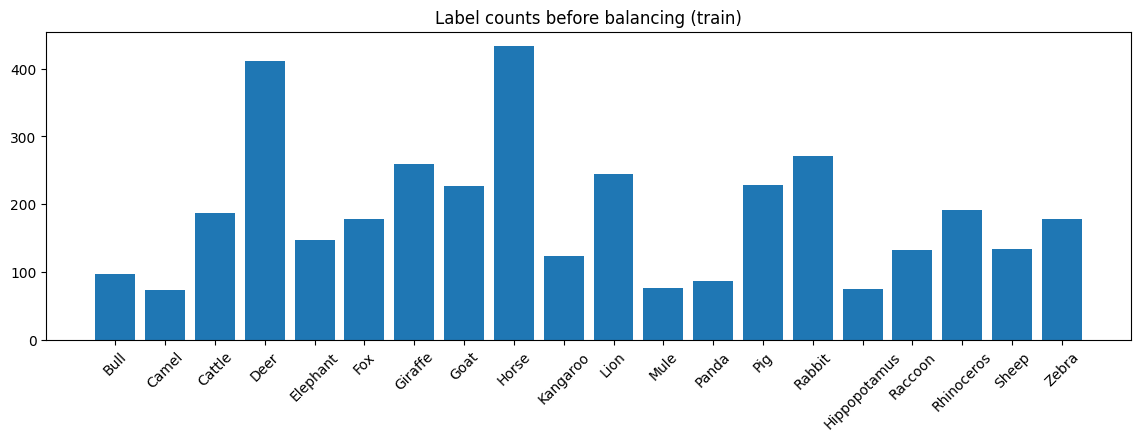

In [8]:
# Count labels per-class in train split by reading YOLO txt files
def count_yolo_labels(split_root):
    counts = {c:0 for c in CLASSES}
    img_dir = os.path.join(split_root, "images")
    lbl_dir = os.path.join(split_root, "labels")
    for img in os.listdir(img_dir) if os.path.isdir(img_dir) else []:
        base = img.rsplit('.',1)[0]
        lbl_file = os.path.join(lbl_dir, base + ".txt")
        if not os.path.exists(lbl_file):
            continue
        with open(lbl_file) as f:
            for line in f:
                parts = line.strip().split()
                if not parts: continue
                cid = int(parts[0])
                if cid < len(CLASSES):
                    counts[CLASSES[cid]] += 1
    return counts

train_counts_yolo = count_yolo_labels(os.path.join(YOLO_ROOT, "train"))
val_counts_yolo   = count_yolo_labels(os.path.join(YOLO_ROOT, "val"))
print("Train label counts (YOLO):")
for c in CLASSES:
    print(c, train_counts_yolo.get(c,0))

# plot distribution
plt.figure(figsize=(14,4))
plt.bar(range(len(CLASSES)), [train_counts_yolo.get(c,0) for c in CLASSES])
plt.xticks(range(len(CLASSES)), CLASSES, rotation=45)
plt.title("Label counts before balancing (train)")
plt.show()


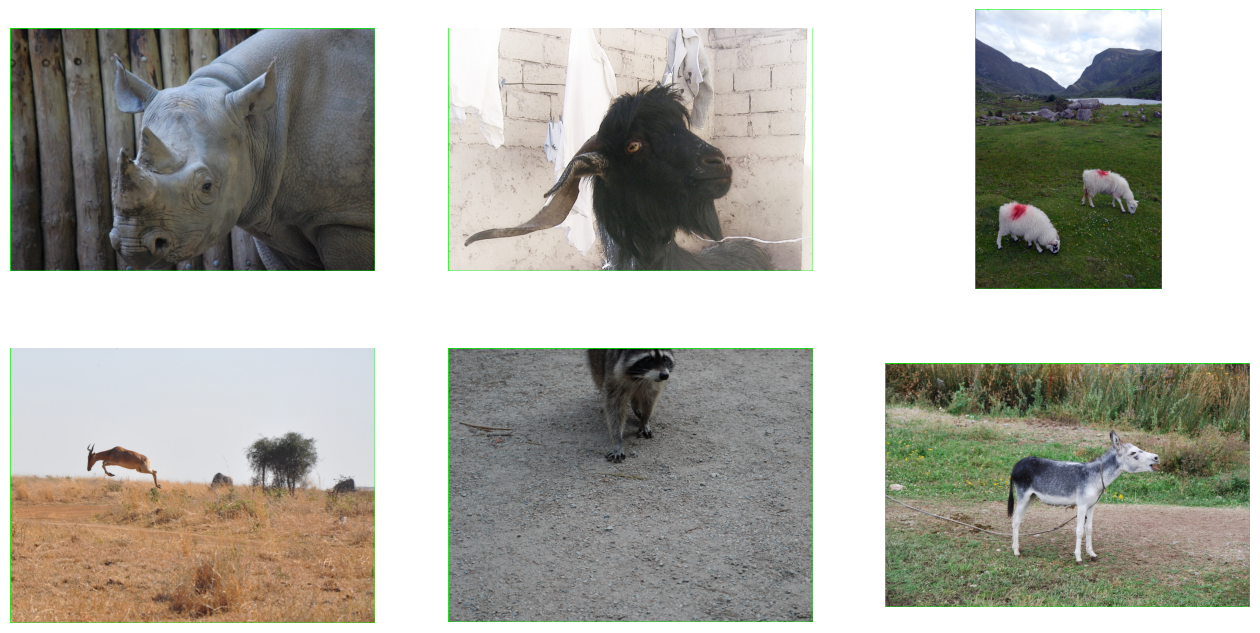

In [9]:
# Draw bounding boxes from YOLO labels on images and show samples
def show_samples(split="train", n=8):
    img_dir = os.path.join(YOLO_ROOT, split, "images")
    lbl_dir = os.path.join(YOLO_ROOT, split, "labels")
    imgs = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    random.shuffle(imgs)
    imgs = imgs[:n]
    plt.figure(figsize=(16,8))
    for i,fn in enumerate(imgs):
        img = cv2.imread(os.path.join(img_dir, fn))
        ih,iw = img.shape[:2]
        base = fn.rsplit('.',1)[0]
        lbl = os.path.join(lbl_dir, base + ".txt")
        if os.path.exists(lbl):
            with open(lbl) as f:
                for line in f:
                    parts = line.strip().split()
                    cid = int(parts[0]); x = float(parts[1]); y = float(parts[2]); w = float(parts[3]); h = float(parts[4])
                    x1 = int((x - w/2)*iw); y1 = int((y - h/2)*ih)
                    x2 = int((x + w/2)*iw); y2 = int((y + h/2)*ih)
                    cv2.rectangle(img, (x1,y1),(x2,y2),(0,255,0),2)
                    cv2.putText(img, CLASSES[cid], (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0),2)
        plt.subplot(2, math.ceil(n/2), i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.show()

show_samples("train", n=6)


In [10]:
import numpy as np

# Patch NumPy 2.0 for imgaug compatibility (adds np.sctypes)
if not hasattr(np, "sctypes"):
    np.sctypes = {
        'int': [np.int8, np.int16, np.int32, np.int64],
        'uint': [np.uint8, np.uint16, np.uint32, np.uint64],
        'float': [np.float16, np.float32, np.float64],
        'complex': [np.complex64, np.complex128],
        'others': [np.bool_, np.str_],  # removed np.unicode_ and np.object_
    }

import imgaug.augmenters as iaa
print(" imgaug imported successfully (NumPy 2.0 compatible).")

 imgaug imported successfully (NumPy 2.0 compatible).


Current max count: 433 target per class: 346
Augmenting class Bull: have 97, need 249
Augmenting class Camel: have 74, need 272
Augmenting class Cattle: have 187, need 159
Augmenting class Elephant: have 147, need 199
Augmenting class Fox: have 178, need 168
Augmenting class Giraffe: have 259, need 87
Augmenting class Goat: have 227, need 119
Augmenting class Kangaroo: have 124, need 222
Augmenting class Lion: have 244, need 102
Augmenting class Mule: have 76, need 270
Augmenting class Panda: have 86, need 260
Augmenting class Pig: have 229, need 117
Augmenting class Rabbit: have 271, need 75
Augmenting class Hippopotamus: have 75, need 271
Augmenting class Raccoon: have 132, need 214
Augmenting class Rhinoceros: have 192, need 154
Augmenting class Sheep: have 134, need 212
Augmenting class Zebra: have 178, need 168
Added new images: 3326


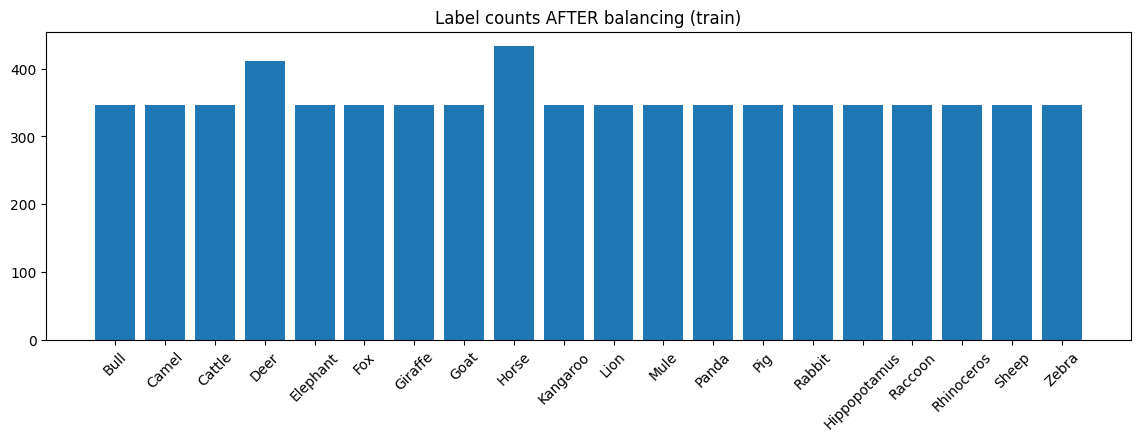

In [11]:
# Balancing by oversampling + horizontal flip + small brightness changes.
import imgaug.augmenters as iaa

def balance_dataset(yolo_root, target_ratio=0.8, max_target=None):
    train_img_dir = os.path.join(yolo_root, "train", "images")
    train_lbl_dir = os.path.join(yolo_root, "train", "labels")
    # count per class
    counts = {c:0 for c in CLASSES}
    files_per_class = {c:[] for c in CLASSES}
    for img in os.listdir(train_img_dir):
        base = img.rsplit('.',1)[0]
        lbl = os.path.join(train_lbl_dir, base + ".txt")
        if not os.path.exists(lbl): continue
        with open(lbl) as f:
            for line in f:
                cid = int(line.split()[0])
                cname = CLASSES[cid]
                counts[cname] += 1
                files_per_class[cname].append(img)
    max_count = max(counts.values()) if counts else 0
    target = int(target_ratio * max_count) if max_target is None else min(max_target, int(target_ratio*max_count))
    print("Current max count:", max_count, "target per class:", target)
    seq = iaa.Sequential([iaa.Multiply((0.8,1.2))])  # brightness variant
    new_images = 0
    for cls in CLASSES:
        ccount = counts.get(cls,0)
        if ccount >= target or ccount==0:
            continue
        needed = target - ccount
        print(f"Augmenting class {cls}: have {ccount}, need {needed}")
        src_list = files_per_class[cls]
        i = 0
        while needed > 0:
            src_fn = src_list[i % len(src_list)]
            src_img_path = os.path.join(train_img_dir, src_fn)
            base = src_fn.rsplit('.',1)[0]
            src_lbl_path = os.path.join(train_lbl_dir, base + ".txt")
            img = cv2.imread(src_img_path)
            ih, iw = img.shape[:2]
            # perform horizontal flip
            flip = cv2.flip(img, 1)
            # read label and update x center = 1 - x_center for flip
            with open(src_lbl_path) as f:
                lines = f.read().strip().splitlines()
            new_base = f"{base}_aug{needed}"
            new_img_name = new_base + ".jpg"
            new_lbl_name = new_base + ".txt"
            cv2.imwrite(os.path.join(train_img_dir, new_img_name), flip)
            # adjust labels
            out_lines = []
            for line in lines:
                parts = line.split()
                cid = parts[0]
                x = float(parts[1]); y = float(parts[2]); w = float(parts[3]); h = float(parts[4])
                x_new = 1.0 - x
                out_lines.append(f"{cid} {x_new:.6f} {y:.6f} {w:.6f} {h:.6f}")
            with open(os.path.join(train_lbl_dir, new_base + ".txt"), "w") as f:
                f.write("\n".join(out_lines))
            # optionally brightness augmentation copy
            aug_img = seq(image=img)
            new_base2 = f"{base}_augB{needed}"
            new_img_name2 = new_base2 + ".jpg"
            new_lbl_name2 = new_base2 + ".txt"
            cv2.imwrite(os.path.join(train_img_dir, new_img_name2), aug_img)
            shutil.copy(os.path.join(train_lbl_dir, base + ".txt"), os.path.join(train_lbl_dir, new_base2 + ".txt"))
            needed -= 2  # we created two images per loop
            new_images += 2
            i += 1
    print("Added new images:", new_images)

# Run balancing (adjust target_ratio if needed, e.g., 0.8)
balance_dataset(YOLO_ROOT, target_ratio=0.8)
# Recompute counts
train_counts_after = count_yolo_labels(os.path.join(YOLO_ROOT, "train"))
plt.figure(figsize=(14,4))
plt.bar(range(len(CLASSES)), [train_counts_after.get(c,0) for c in CLASSES])
plt.xticks(range(len(CLASSES)), CLASSES, rotation=45)
plt.title("Label counts AFTER balancing (train)")
plt.show()


In [12]:
data_yaml = {
    "path": YOLO_ROOT,
    "train": "train/images",
    "val": "val/images",
    "test": "test/images",
    "names": {i:name for i,name in enumerate(CLASSES)}
}
import yaml
with open(os.path.join(YOLO_ROOT, "data.yaml"), "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)
print("Wrote", os.path.join(YOLO_ROOT,"data.yaml"))
print(open(os.path.join(YOLO_ROOT,"data.yaml")).read())


Wrote /content/yolo_dataset/data.yaml
path: /content/yolo_dataset
train: train/images
val: val/images
test: test/images
names:
  0: Bull
  1: Camel
  2: Cattle
  3: Deer
  4: Elephant
  5: Fox
  6: Giraffe
  7: Goat
  8: Horse
  9: Kangaroo
  10: Lion
  11: Mule
  12: Panda
  13: Pig
  14: Rabbit
  15: Hippopotamus
  16: Raccoon
  17: Rhinoceros
  18: Sheep
  19: Zebra



In [13]:
# Bash cell
# Ensure ultralytics installed (should be from cell 1); still safe to run:
! pip install -q ultralytics


In [14]:
!python yolov5/train.py --img 320 --batch 32 --epochs 75 \
    --data /content/yolo_dataset/data.yaml \
    --weights yolov5n.pt \
    --name animals_detect_v5n

Streaming output truncated to the last 5000 lines.
  with torch.cuda.amp.autocast(amp):
      63/74      1.38G    0.00479    0.00374    0.04304         96        320:  94% 209/222 [00:33<00:02,  5.03it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      63/74      1.38G    0.00479   0.003739    0.04305         96        320:  94% 209/222 [00:33<00:02,  5.03it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      63/74      1.38G   0.004787    0.00374    0.04307         82        320:  95% 211/222 [00:33<00:01,  6.04it/s]/content/yolov5/train.py:414: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(

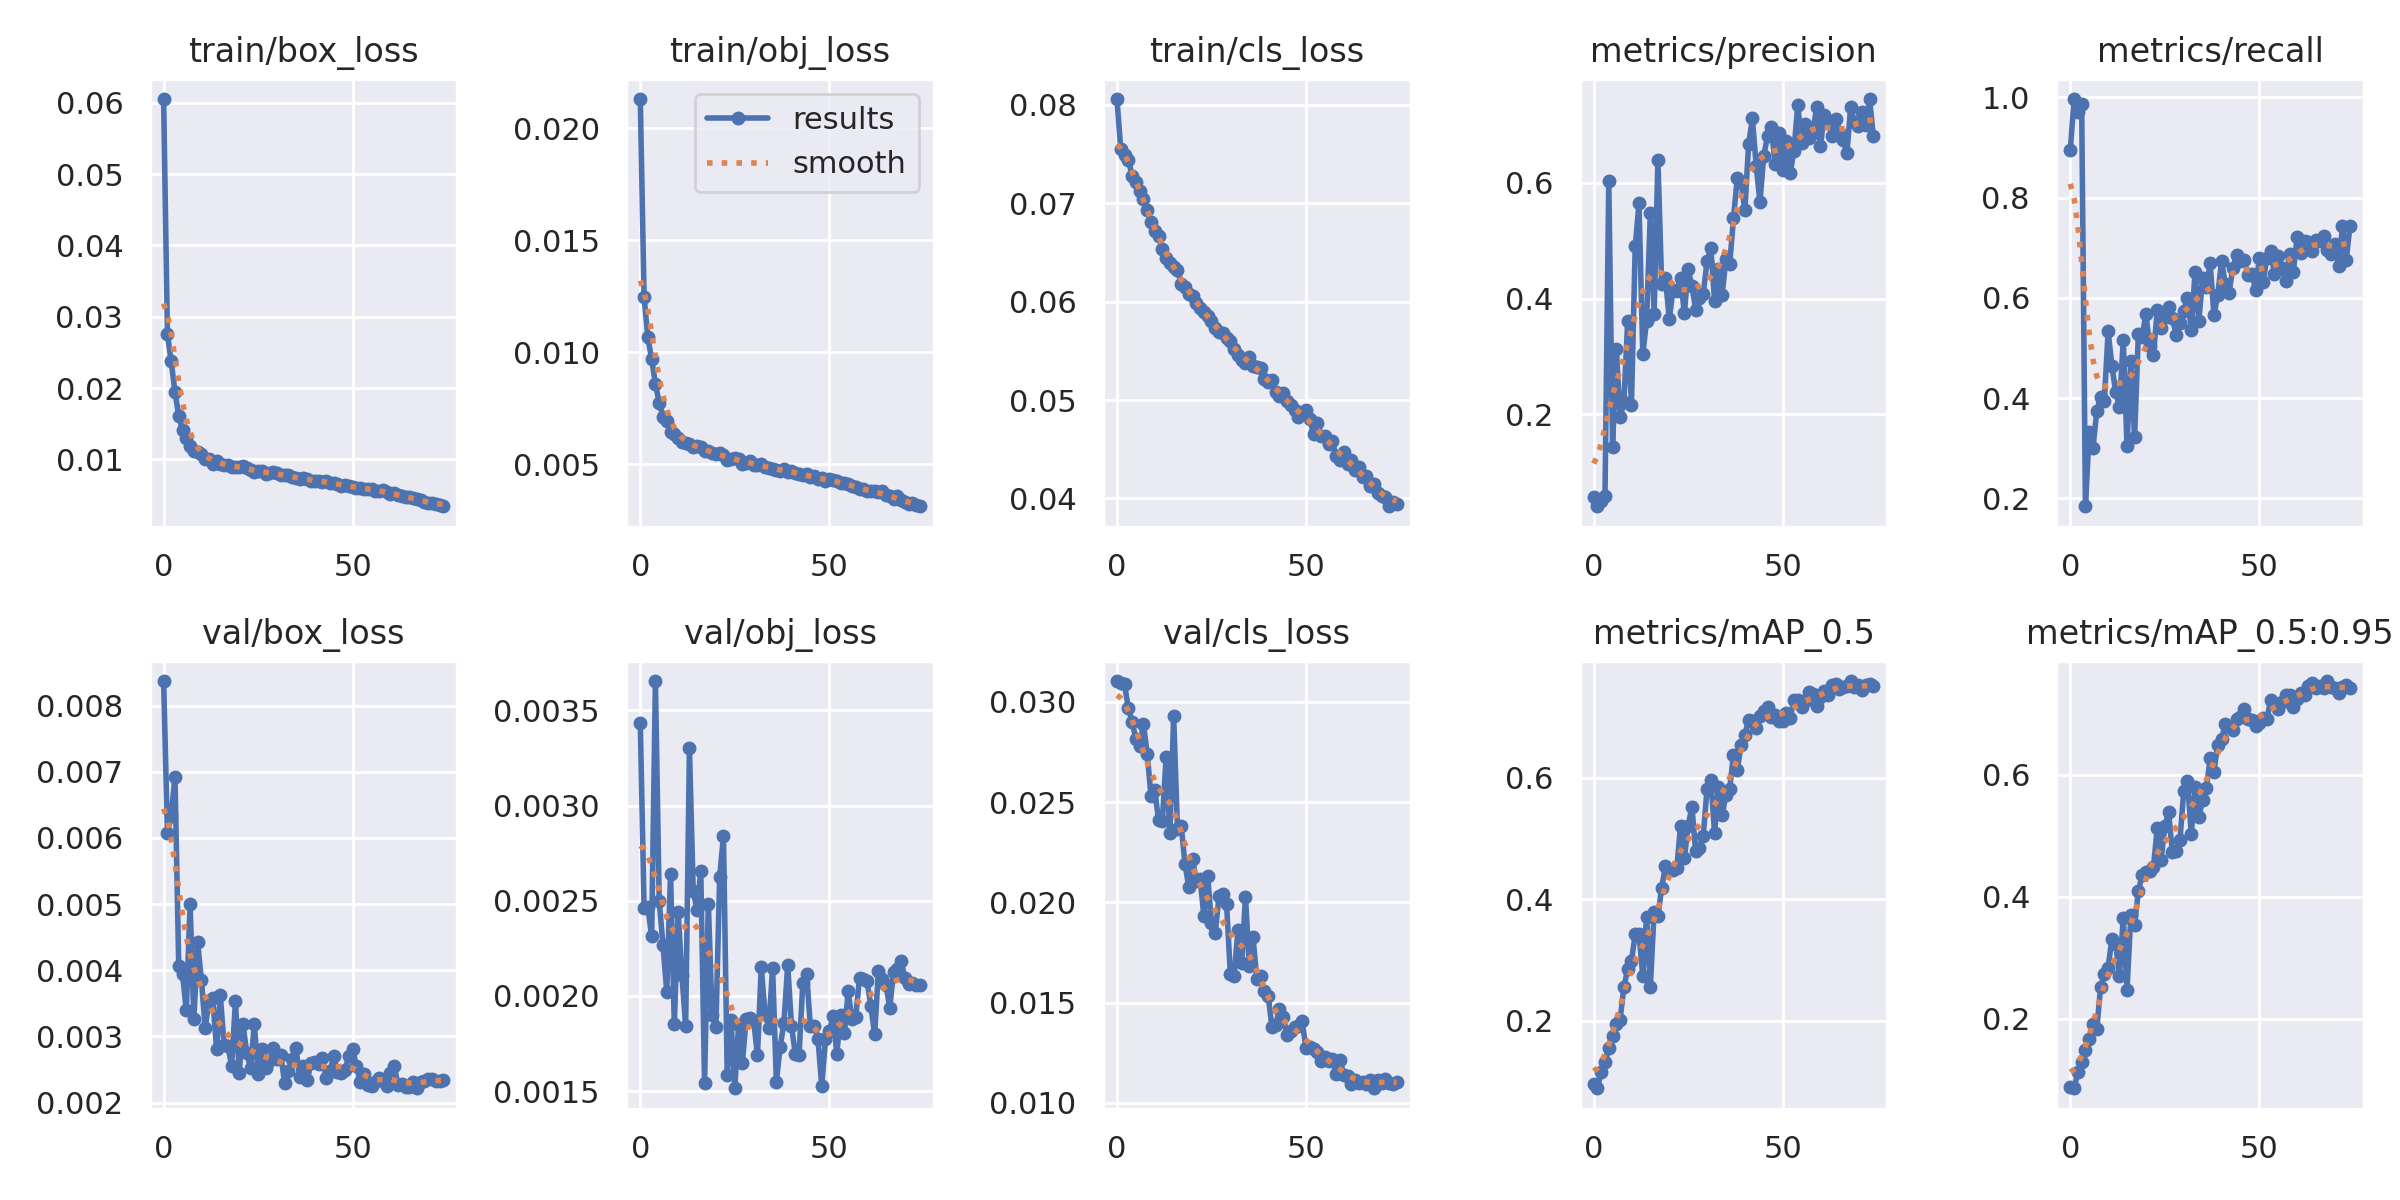

In [16]:
import os
from IPython.display import Image, display

# Path to YOLOv5 training results
res_png = "yolov5/runs/train/animals_detect_v5n/results.png"

if os.path.exists(res_png):
    display(Image(filename=res_png))
else:
    print("results.png not found. Check path: yolov5/runs/train/animals_detect_v5n/")

In [24]:
!python yolov5/val.py \
    --weights yolov5/runs/train/animals_detect_v5n/weights/best.pt \
    --data /content/yolo_dataset/data.yaml \
    --img 320

val: data=/content/yolo_dataset/data.yaml, weights=['yolov5/runs/train/animals_detect_v5n/weights/best.pt'], batch_size=32, imgsz=320, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-448-gdeec5e45 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-80GB, 81222MiB)

Fusing layers... 
Model summary: 157 layers, 1786225 parameters, 0 gradients, 4.2 GFLOPs
val: Scanning /content/yolo_dataset/val/labels.cache... 469 images, 0 backgrounds, 0 corrupt: 100% 469/469 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 15/15 [00:04<00:00,  3.54it/s]
                   all        469        469      0.731      0.686      0.759      0.755
                  Bull        469         13      0.608      0.538  

In [25]:
!python yolov5/detect.py \
    --weights yolov5/runs/train/animals_detect_v5n/weights/best.pt \
    --source /content/yolo_dataset/test/images \
    --save-img --save-conf --save-txt

usage: detect.py [-h] [--weights WEIGHTS [WEIGHTS ...]] [--source SOURCE]
                 [--data DATA] [--imgsz IMGSZ [IMGSZ ...]]
                 [--conf-thres CONF_THRES] [--iou-thres IOU_THRES]
                 [--max-det MAX_DET] [--device DEVICE] [--view-img]
                 [--save-txt] [--save-format SAVE_FORMAT] [--save-csv]
                 [--save-conf] [--save-crop] [--nosave]
                 [--classes CLASSES [CLASSES ...]] [--agnostic-nms]
                 [--augment] [--visualize] [--update] [--project PROJECT]
                 [--name NAME] [--exist-ok] [--line-thickness LINE_THICKNESS]
                 [--hide-labels] [--hide-conf] [--half] [--dnn]
                 [--vid-stride VID_STRIDE]
detect.py: error: unrecognized arguments: --save-img


In [27]:
import os
import cv2
import matplotlib.pyplot as plt

# Possible prediction roots for YOLOv5
possible_roots = [
    "yolov5/runs/detect",
    "runs/detect"
]

pred_root = None

# Find which path exists
for root in possible_roots:
    if os.path.isdir(root):
        pred_root = root
        break

if pred_root is None:
    print(" No YOLOv5 prediction directory found in any expected location.")
else:
    print(" Using prediction directory:", pred_root)

    # List all "exp" folders
    exp_folders = [f for f in os.listdir(pred_root) if f.startswith("exp")]

    if not exp_folders:
        print(" No prediction folders (exp) found inside:", pred_root)
    else:
        # Sort by number (exp, exp2, exp3...)
        exp_folders.sort(key=lambda x: int(x.replace("exp", "") or 0))
        latest_exp = exp_folders[-1]

        pred_dir = os.path.join(pred_root, latest_exp)
        print("Displaying predictions from:", pred_dir)

        # Load images
        imgs = [f for f in os.listdir(pred_dir) if f.lower().endswith((".jpg", ".png"))]

        if not imgs:
            print(" No predicted images found inside:", pred_dir)
        else:
            imgs = imgs[:6]  # show max 6 images

            plt.figure(figsize=(16, 8))
            for i, fn in enumerate(imgs):
                img_path = os.path.join(pred_dir, fn)
                img = cv2.imread(img_path)

                if img is None:
                    continue

                plt.subplot(2, 3, i + 1)
                plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                plt.axis("off")

            plt.show()

 No YOLOv5 prediction directory found in any expected location.


In [30]:
!python yolov5/export.py \
    --weights yolov5/runs/train/animals_detect_v5n/weights/best.pt \
    --include tflite \
    --img 320 \
    --batch 1

export: data=yolov5/data/coco128.yaml, weights=['yolov5/runs/train/animals_detect_v5n/weights/best.pt'], imgsz=[320], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, cache=, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tflite']
YOLOv5 🚀 v7.0-448-gdeec5e45 Python-3.12.12 torch-2.8.0+cu126 CPU

Fusing layers... 
Model summary: 157 layers, 1786225 parameters, 0 gradients, 4.2 GFLOPs

PyTorch: starting from yolov5/runs/train/animals_detect_v5n/weights/best.pt with output shape (1, 6300, 25) (3.6 MB)
2025-11-16 21:32:57.667210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763328777.689220   24037 cuda_dnn.cc:8579] Unable to register cuD

In [31]:
import glob
import shutil
import os

# Look for YOLOv5 exported TFLite model
tflite_matches = glob.glob("yolov5/runs/train/animals_detect_v5n/weights/*.tflite")

if tflite_matches:
    tflite_path = tflite_matches[0]

    # Copy to accessible location
    shutil.copy(tflite_path, "/content/best_animals.tflite")

    # Save class names
    with open("/content/classes.txt", "w") as f:
        f.write("\n".join(CLASSES))

    print(" Saved /content/best_animals.tflite and /content/classes.txt")
else:
    print(" No TFLite model found. Check export step or folder path.")


 Saved /content/best_animals.tflite and /content/classes.txt
